In [1]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


##Preprocess define
Remove stopwords, ULRs, usernames, punctuations, numbers, and special characters.

In [43]:
#Preprocessing function for dataframe, to be used later on
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    stop_words.add('br')
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

def preprocess_text(data):
    data['text'] = data['text'].apply(remove_stopwords)#Remove stopwords
    data['text'] = data['text'].apply(lambda x: re.sub('https?:\/\/.*[\r\n]*', ' ', x))#Remove URLs
    data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-Z0-9 \n]', ' ', x))#Remove non-alphanumeric characters
    data['text'] = data['text'].apply(lambda x: re.sub('@[\w]*', '', x))#Remove Twitter usernames
    data['text'] = data['text'].apply(lambda x: re.sub('\d+', ' ', x))#Remove digits
    data['text'] = data['text'].apply(lambda x: re.sub('user', '', x))#Remove Twitter usernames
    data['text'] = data['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))#Remove Short Words
    data['text'] = data['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))#Remove punctuation
    data['text'] = data['text'].str.lower()
    return data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##Loading Libraries and Data
Given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist

In [44]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv('/content/twitter_E6oV3lV.csv')
data.columns=['id','label','text']
#print(data['label'].value_counts())
print("Class Distribution:")
print(data['label'].value_counts(normalize=True))

Class Distribution:
label
0    0.929854
1    0.070146
Name: proportion, dtype: float64


In [45]:
from sklearn.utils import resample

class_0 = data[data['label'] == 0]
class_1 = data[data['label'] == 1]

majority_class = 0 if len(class_0) > len(class_1) else 1
minority_class = 1 - majority_class

#Downsamle
class_majority_downsampled = resample(class_0 if majority_class == 0 else class_1,
                                      replace=False,
                                      n_samples=len(class_1),
                                      random_state=42)
#Merge balanced data
balanced_data = pd.concat([class_majority_downsampled, class_1] if majority_class == 0 else [class_0, class_majority_downsampled])
#print(balanced_data['label'].value_counts())
print("Class Distribution:")
print(balanced_data['label'].value_counts(normalize=True))

Class Distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [58]:
from sklearn.model_selection import train_test_split
#Segment dataset
train_data, test_data = train_test_split(balanced_data, test_size=0.2, random_state=42)
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)
train_data = pd.read_csv('/content/train_data.csv')
test_data = pd.read_csv('/content/test_data.csv')

train_data.columns=['id','label','text']
test_data.columns=['id','label','text']

train_data.head()

,id,label,text
0,5280,0,sad world... #orlando #tuerie #terrorism #usa
1,15986,1,@user i know. ref. to #malevote &amp; #womenvo...
2,6018,0,priority tou choro koi 2nd option tk ni banata...
3,27315,0,@user arr look at taylor on the slide!! ð ...
4,3139,1,@user you might be a libtard if... #libtard #...


##Preprocessing

In [59]:
train_data = preprocess_text(train_data)
test_data = preprocess_text(test_data)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['text'])
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

X_train = pad_sequences(train_sequences, maxlen=100)
X_test = pad_sequences(test_sequences, maxlen=100)

y_train = train_data['label'].values
y_test = test_data['label'].values

train_data.head()

,id,label,text
0,5280,0,sad world orlando tuerie terrorism usa
1,15986,1,know ref malevote amp womenvote profiling ref ...
2,6018,0,priority tou choro koi nd option tk ni banata ...
3,27315,0,arr look taylor slide sister
4,3139,1,might libtard libtard sjw liberal politics


Class Distribution:
label
0    0.501533
1    0.498467
Name: proportion, dtype: float64


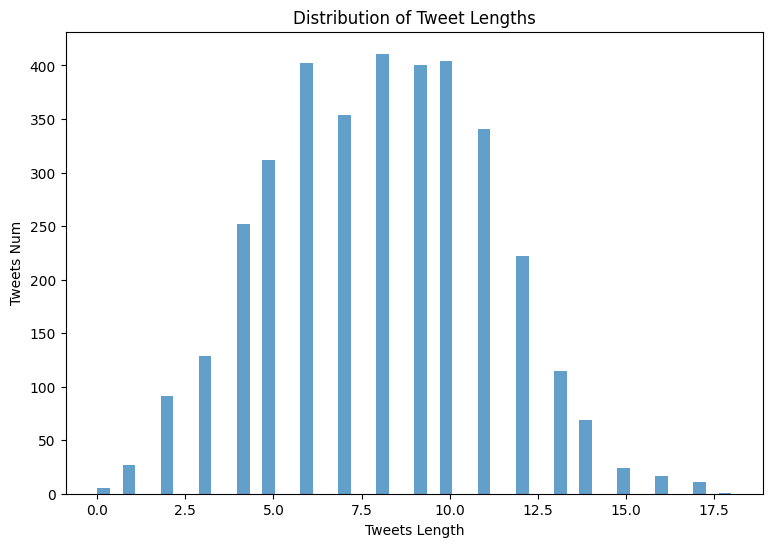

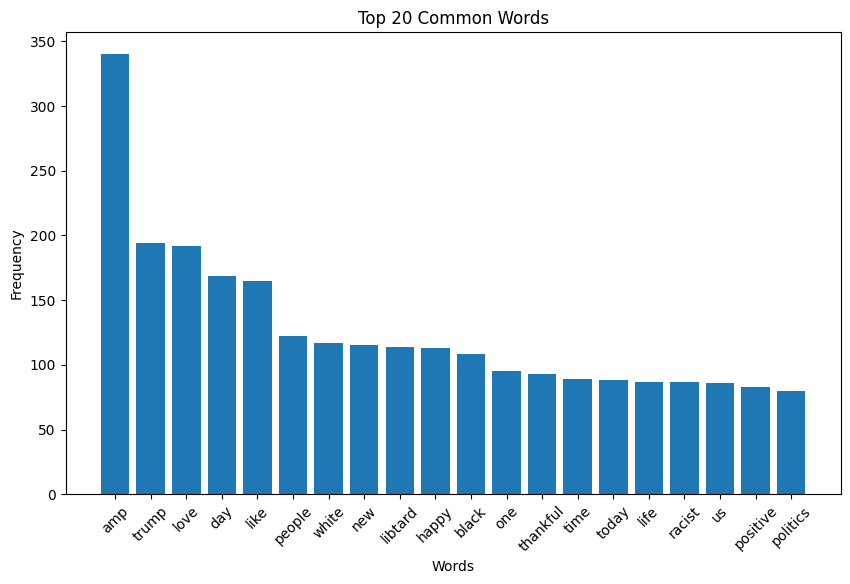

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize

print("Class Distribution:")
print(train_data['label'].value_counts(normalize=True))

review_lengths = train_data['text'].apply(lambda x: len(word_tokenize(x)))
plt.figure(figsize=(9, 6))
plt.hist(review_lengths, bins=50, alpha=0.7)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweets Length')
plt.ylabel('Tweets Num')
plt.show()


stop_words = set(stopwords.words('english'))
stop_words.add('br')
all_words = [word for review in train_data['text'] for word in word_tokenize(review.lower()) if word.isalpha() and word not in stop_words]

word_freq = Counter(all_words).most_common(20)

words, frequencies = zip(*word_freq)
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Top 20 Common Words')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


##Model training and evaluation
Simple RNN

Epoch 1/5
23/23 [==============================] - 3s 65ms/step - loss: 0.6839 - accuracy: 0.5706 - val_loss: 0.6591 - val_accuracy: 0.6476
Epoch 2/5
23/23 [==============================] - 1s 37ms/step - loss: 0.5753 - accuracy: 0.8641 - val_loss: 0.5977 - val_accuracy: 0.7033
Epoch 3/5
23/23 [==============================] - 1s 37ms/step - loss: 0.3916 - accuracy: 0.9285 - val_loss: 0.5018 - val_accuracy: 0.7591
Epoch 4/5
23/23 [==============================] - 1s 37ms/step - loss: 0.2016 - accuracy: 0.9683 - val_loss: 0.4269 - val_accuracy: 0.8162
Epoch 5/5
29/29 [==============================] - 0s 6ms/step


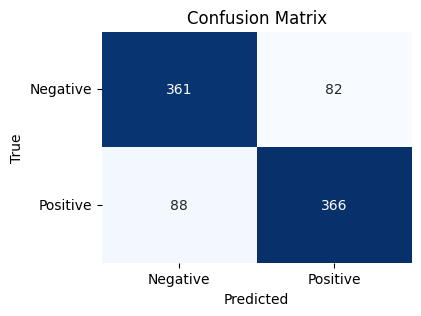

29/29 [==============================] - 0s 7ms/step


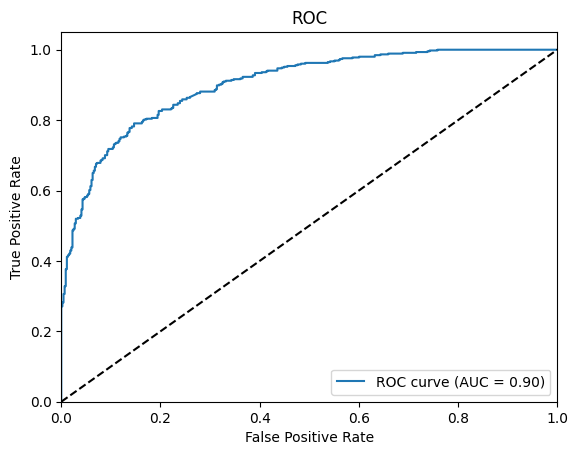

Precision: 0.8170, Recall: 0.8062, F1: 0.8115, AUC: 0.9009


In [63]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=100),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2)
predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()

precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'], rotation=0)
plt.show()

y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")

In [64]:
import joblib
# save the model to a file
joblib.dump(model, 'RNN_model.joblib')

['RNN_model.joblib']

##Change the model
LSTM

Epoch 1/5
45/45 [==============================] - 6s 86ms/step - loss: 0.6716 - accuracy: 0.6532 - val_loss: 0.6158 - val_accuracy: 0.7869
Epoch 2/5
45/45 [==============================] - 3s 68ms/step - loss: 0.4519 - accuracy: 0.8627 - val_loss: 0.4146 - val_accuracy: 0.8496
Epoch 3/5
45/45 [==============================] - 2s 54ms/step - loss: 0.2404 - accuracy: 0.9488 - val_loss: 0.3315 - val_accuracy: 0.8565
Epoch 4/5
45/45 [==============================] - 2s 52ms/step - loss: 0.1183 - accuracy: 0.9704 - val_loss: 0.3156 - val_accuracy: 0.8565
Epoch 5/5
29/29 [==============================] - 1s 11ms/step


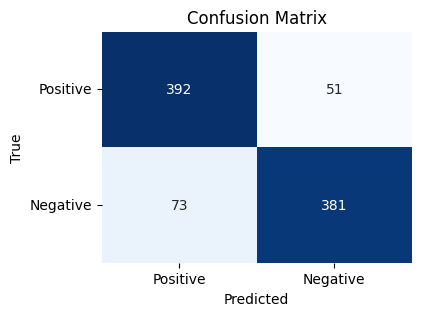

29/29 [==============================] - 0s 11ms/step


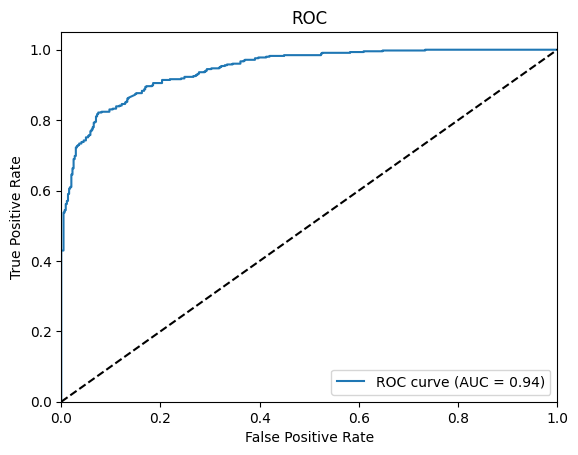

Precision: 0.8819, Recall: 0.8392, F1: 0.8600, AUC: 0.9447


In [23]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=100),
    LSTM(32),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.2)

predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()

precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Positive', 'Negative'])
plt.yticks(ticks=[0.5, 1.5], labels=['Positive', 'Negative'], rotation=0)
plt.show()

y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")

In [ ]:
# save the model to a file
joblib.dump(model, 'LSTM_model.joblib')

##Change the model
CNN+BiLSTM

Epoch 1/5
45/45 [==============================] - 13s 158ms/step - loss: 0.6904 - accuracy: 0.5403 - val_loss: 0.6744 - val_accuracy: 0.7827
Epoch 2/5
45/45 [==============================] - 4s 97ms/step - loss: 0.4834 - accuracy: 0.8519 - val_loss: 0.3583 - val_accuracy: 0.8412
Epoch 3/5
45/45 [==============================] - 6s 140ms/step - loss: 0.1625 - accuracy: 0.9428 - val_loss: 0.3468 - val_accuracy: 0.8510
Epoch 4/5
45/45 [==============================] - 4s 99ms/step - loss: 0.0695 - accuracy: 0.9787 - val_loss: 0.3669 - val_accuracy: 0.8524
Epoch 5/5
29/29 [==============================] - 2s 30ms/step


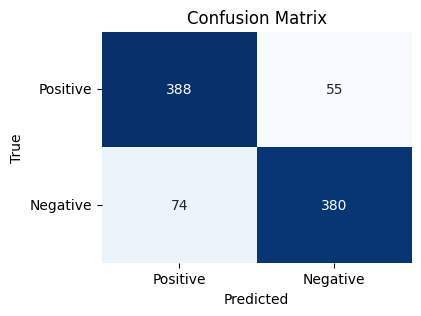

29/29 [==============================] - 1s 17ms/step


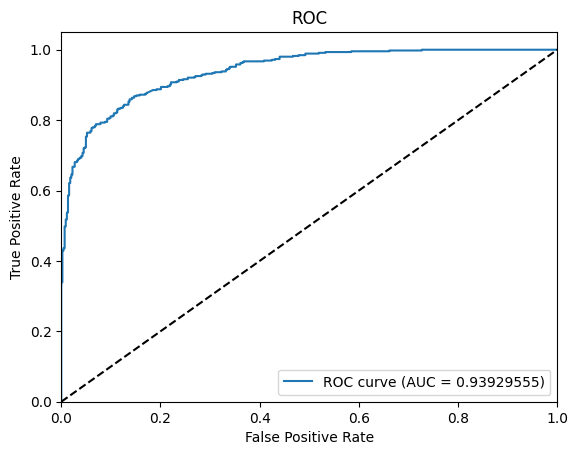

Precision: 0.8736, Recall: 0.8370, F1: 0.8549, AUC: 0.9393


In [24]:
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Dense
model = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=100),
    SpatialDropout1D(0.2),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.2)

predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()

precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Positive', 'Negative'])
plt.yticks(ticks=[0.5, 1.5], labels=['Positive', 'Negative'], rotation=0)
plt.show()

y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.8f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")

In [ ]:
# save the model to a file
joblib.dump(model, 'CNNLSTM_model.joblib')

##Imbalanced dataset

In [36]:
data=pd.read_csv('/content/twitter_E6oV3lV.csv')
#segment dataset
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)
train_data = pd.read_csv('/content/train_data.csv')
test_data = pd.read_csv('/content/test_data.csv')

data.columns=['id','label','text']
train_data.columns=['id','label','text']
test_data.columns=['id','label','text']

train_data = preprocess_text(train_data)
test_data = preprocess_text(test_data)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['text'])
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

X_train = pad_sequences(train_sequences, maxlen=100)
X_test = pad_sequences(test_sequences, maxlen=100)

y_train = train_data['label'].values
y_test = test_data['label'].values

train_data.head()

,id,label,text
0,12111,1,ve paying attention past year years
1,14082,0,raft building salford quays pa gmw fun outdoor...
2,1830,0,friday gdegblog friday selfie beard gayguy gay...
3,2770,0,fashion true fact
4,31819,0,share simple elegant businesscards designed gr...


Class Distribution:
label
0    0.93015
1    0.06985
Name: proportion, dtype: float64


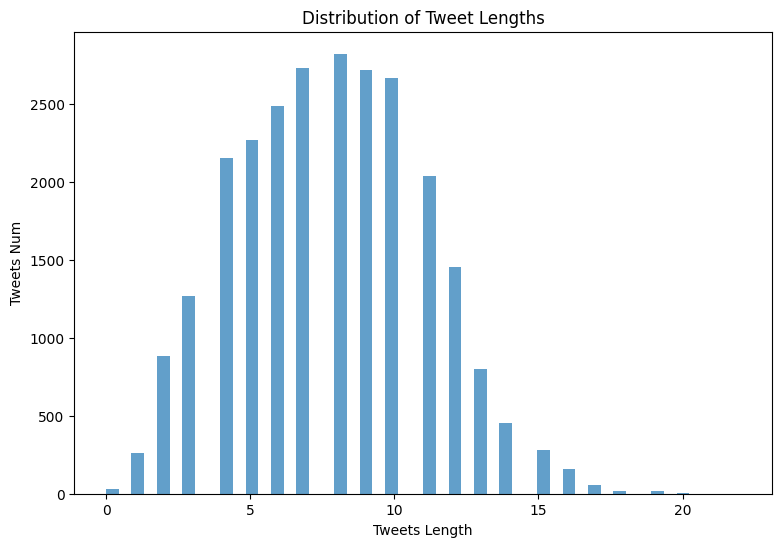

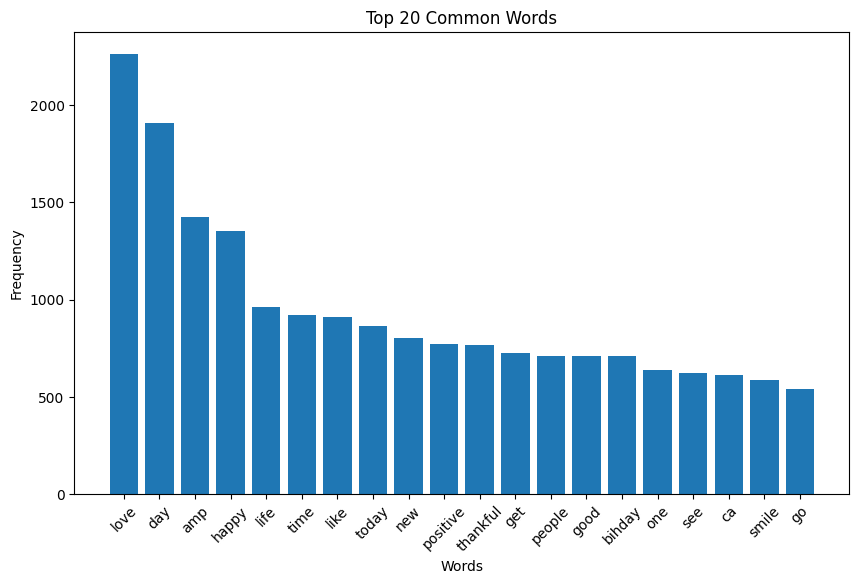

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize

print("Class Distribution:")
print(train_data['label'].value_counts(normalize=True))

review_lengths = train_data['text'].apply(lambda x: len(word_tokenize(x)))
plt.figure(figsize=(9, 6))
plt.hist(review_lengths, bins=50, alpha=0.7)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweets Length')
plt.ylabel('Tweets Num')
plt.show()


stop_words = set(stopwords.words('english'))
stop_words.add('br')
all_words = [word for review in train_data['text'] for word in word_tokenize(review.lower()) if word.isalpha() and word not in stop_words]

word_freq = Counter(all_words).most_common(20)

words, frequencies = zip(*word_freq)
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Top 20 Common Words')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


WordCloud: Words like love, great, friend, life are the most frequent ones. It doesn’t give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes (racist/sexist or not) in our train data.

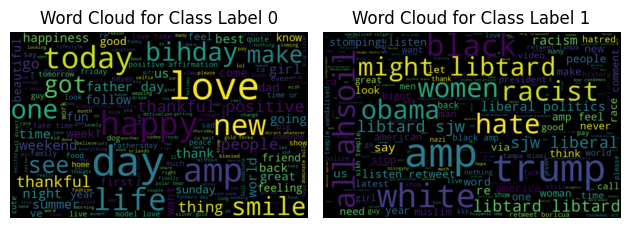

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud for class label 0
normal_words_0 = ' '.join([text for text in train_data['text'][train_data['label'] == 0]])
wordcloud_0 = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words_0)
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_0, interpolation="bilinear")
plt.title('Word Cloud for Class Label 0')
plt.axis('off')

# Generate word cloud for class label 1
normal_words_1 = ' '.join([text for text in train_data['text'][train_data['label'] == 1]])
wordcloud_1 = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words_1)
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.title('Word Cloud for Class Label 1')
plt.axis('off')

plt.tight_layout()
plt.show()


LSTM as example

Epoch 1/5
320/320 [==============================] - 24s 67ms/step - loss: 0.2281 - accuracy: 0.9335 - val_loss: 0.1316 - val_accuracy: 0.9537
Epoch 2/5
320/320 [==============================] - 20s 61ms/step - loss: 0.0880 - accuracy: 0.9704 - val_loss: 0.1235 - val_accuracy: 0.9580
Epoch 3/5
320/320 [==============================] - 19s 60ms/step - loss: 0.0520 - accuracy: 0.9835 - val_loss: 0.1345 - val_accuracy: 0.9593
Epoch 4/5
320/320 [==============================] - 21s 64ms/step - loss: 0.0380 - accuracy: 0.9879 - val_loss: 0.1551 - val_accuracy: 0.9583
Epoch 5/5
200/200 [==============================] - 3s 12ms/step


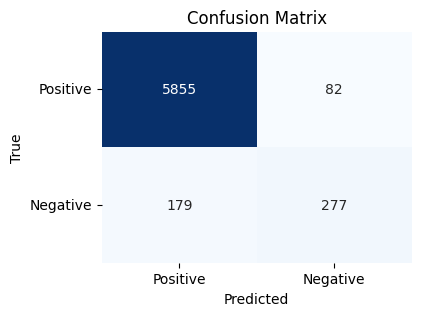

200/200 [==============================] - 3s 15ms/step


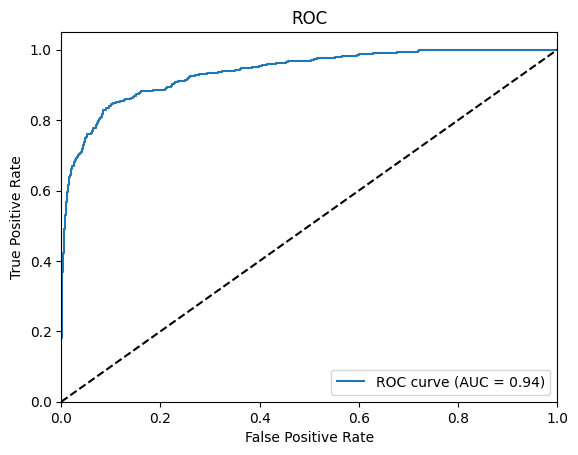

Precision: 0.7716, Recall: 0.6075, F1: 0.6798, AUC: 0.9369


In [38]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=100),
    LSTM(32),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.2)

predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()

precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Positive', 'Negative'])
plt.yticks(ticks=[0.5, 1.5], labels=['Positive', 'Negative'], rotation=0)
plt.show()

y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")

If the labels of the dataset are imbalanced, it may have an impact on the performance of the model. Specifically, if the number of samples in one category far exceeds that of another category, the model may tend to learn more categories with more samples, resulting in poor predictive performance for minority categories.